<a href="https://colab.research.google.com/github/darja/NeuralUni/blob/master/21_pytorch_cifar_pro_ryazhskikh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация изображений с помощью PyTorch

**Входные параметры:**

Готовая архитектура сети CustomNet для распознования CIFAR-10

**Задание:**
1. Обучить сверточную сеть на датасете CIFAR-10 с разными функциями активациями, добавить слои свертки и пулинга, добавить нейронов и написать отчет об изменениях точностей.
2. Получить accuracy близкий к 0.8 и выше
3. Доп задание по желанию: получить score >= 0.75 на датасете CIFAR-100

# Подготовка окружения

In [0]:
import torchvision.datasets
import torch
import torch.nn as nn
from torchsummary import summary
from collections import OrderedDict

import numpy as np
from matplotlib import pyplot as plt

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Подготовка входных данных

In [0]:
cifar_train = torchvision.datasets.CIFAR10('./',download=True,train=True)
cifar_test = torchvision.datasets.CIFAR10('./',download=True,train=False)

X_train = torch.FloatTensor(cifar_train.data)
y_train = torch.LongTensor(cifar_train.targets)

X_test = torch.FloatTensor(cifar_test.data)
y_test = torch.LongTensor(cifar_test.targets)

# Нормализация
X_train /= 255.
X_test /= 255.

# меняем порядок размерности
X_train = X_train.permute(0,3,1,2)
X_test = X_test.permute(0,3,1,2)

0it [00:00, ?it/s]

170500096it [00:02, 68360610.63it/s]                               


Files already downloaded and verified


## Просмотр входных данных

In [0]:
cifar_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [0]:
print("Train dataset: ", X_train.shape)
print("Train labels: ", y_train.shape)
print("\nTest dataset: ", X_test.shape)
print("Test labels: ", y_test.shape)

Train dataset:  torch.Size([50000, 3, 32, 32])
Train labels:  torch.Size([50000])

Test dataset:  torch.Size([10000, 3, 32, 32])
Test labels:  torch.Size([10000])


# Нейросеть

## Классы-помощники

In [0]:
class ConvBlock(nn.Sequential):
    def __init__(self, args):
        in_features, out_features, kernel, padding, dropout = args
        super().__init__(
            nn.Conv2d(in_features, out_features, kernel, padding = padding),
            nn.ReLU(),
            nn.BatchNorm2d(out_features),
            nn.Conv2d(out_features, out_features, kernel, padding = padding),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
#             nn.Dropout2d(dropout),
            nn.BatchNorm2d(out_features),
        )

        
class DenseBlock(nn.Sequential):
    def __init__(self, args):
        in_features, out_features, dropout = args
        super().__init__(
            nn.Linear(in_features, out_features),
#             nn.ReLU(),
            nn.Tanh(),
            nn.BatchNorm1d(out_features),
#             nn.Dropout(dropout)
        )

class CustomNet(nn.Module):
    def __init__(self, conv_structure, classification_structure):
        super(CustomNet,self).__init__()
        self.bn0 = nn.BatchNorm2d(3)
        
        conv_blocks = OrderedDict()
        for i in range(len(conv_structure)):
            conv_blocks[f"Conv_{i}"] = ConvBlock(conv_structure[i])
        self.conv_sequence = nn.Sequential(conv_blocks)
        print("*** Convolution part ***\n", self.conv_sequence)
        
        classification_blocks = OrderedDict()
        for i in range(len(classification_structure)):
            classification_blocks[f"Class_{i}"] = DenseBlock(classification_structure[i])
        self.classification_sequence = nn.Sequential(classification_blocks)
        print("\n*** Classification part ***\n", self.classification_sequence)

    def forward(self, x):
        x = self.bn0(x)
        x = self.conv_sequence(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.classification_sequence(x)
        return x
    
class FitMetrics:
    def __init__(self):
        self.train_acc = []
        self.val_acc = []
        self.train_loss = []
        self.val_loss = []
        self.batch_size = 1000
        
    def eval_dataset(self, model, dataset, expected):
        n = len(dataset)
        dataset_loss = []
        dataset_acc = []
        for start_index in range(0, n, self.batch_size):
            print("\r", end=f"Epoch {epoch}: ")

            X_batch = dataset[start_index:start_index + batch_size].to(device)
            y_batch = expected[start_index:start_index + batch_size].to(device)

            predictions = custom_net.forward(X_batch)
            dataset_loss.append(loss(predictions, y_batch).data.cpu())
            dataset_acc.append((predictions.argmax(dim=1) == y_batch).float().mean().data.cpu())
            
        return np.mean(dataset_loss), np.mean(dataset_acc)
    
    def append(self, model, X_train, y_train, X_test, y_test):
        train_loss, train_acc = self.eval_dataset(model, X_train, y_train)
        val_loss, val_acc = self.eval_dataset(model, X_test, y_test)
        
        self.train_loss.append(train_loss)
        self.train_acc.append(train_acc)
        self.val_loss.append(val_loss)
        self.val_acc.append(val_acc)
        
    def latest_summary(self):
        return f"loss: {self.train_loss[-1]}, acc: {self.train_acc[-1]}, val_loss: {self.val_loss[-1]}, val_acc: {self.val_acc[-1]}"

## Создание нейросети

In [0]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# custom_net = CustomNet(
#     conv_structure = [
#         (3, 16, 3, 1), 
#         (16, 32, 3, 1),
#         (32, 64, 3, 1)],
#     classification_structure = [
#         (4 * 4 * 64, 256),
#         (256, 64),
#         (64, 10)
#     ]
# ).to(device)

# custom_net = CustomNet(
#     conv_structure = [
#         (3, 16, 3, 1, 0.3), 
#         (16, 32, 3, 1, 0.3),
#         (32, 64, 3, 1, 0.3)],
#     classification_structure = [
#         (4 * 4 * 64, 1000, 0.1),
#         (1000, 10, 0)
#     ]
# ).to(device)

custom_net = CustomNet(
    conv_structure = [
        (3, 32, 3, 1, 0.1),
        (32, 64, 3, 1, 0.1),
        (64, 128, 3, 1, 0.1)],
    classification_structure = [
        (2048, 128, 0.1),
        (128, 10, 0)
    ]
).to(device)

summary(custom_net, (3, 32, 32))


loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_net.parameters(),lr=1.0e-3)

*** Convolution part ***
 Sequential(
  (Conv_0): ConvBlock(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv_1): ConvBlock(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv_2): ConvBlock

## Обучение нейросети

### Обучение с увеличением batch_size

In [0]:
batch_size = 64

n = len(X_train)
metrics = FitMetrics()

for epoch in range(100):
    order = np.random.permutation(n)
    
    if batch_size > 10 and epoch > 0 and epoch % 10 == 0:
        batch_size *= 2
        print(f"Changing batch size to {batch_size}")
  
    print("\r", end=f"Epoch {epoch}: ")
    for start_index in range(0, n, batch_size):
        
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index + batch_size]

        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        preds = custom_net.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()
    
    # Calculate train acc and loss
    metrics.append(custom_net, X_train, y_train, X_test, y_test)
    print(metrics.latest_summary())

Epoch 0: loss: 0.24898378551006317, acc: 0.9140625, val_loss: 0.780524730682373, val_acc: 0.7984374761581421
Epoch 1: loss: 0.17665189504623413, acc: 0.948437511920929, val_loss: 0.794297456741333, val_acc: 0.796875
Epoch 2: loss: 0.15142998099327087, acc: 0.9512500166893005, val_loss: 0.8326318860054016, val_acc: 0.800000011920929
Epoch 3: loss: 0.14354398846626282, acc: 0.9587500095367432, val_loss: 0.8564239740371704, val_acc: 0.8046875
Epoch 4: loss: 0.13065572082996368, acc: 0.9612500071525574, val_loss: 0.8048824071884155, val_acc: 0.8046875
Epoch 5: loss: 0.12028111517429352, acc: 0.9649999737739563, val_loss: 0.7691403031349182, val_acc: 0.823437511920929
Epoch 6: loss: 0.12029814720153809, acc: 0.9649999737739563, val_loss: 0.8838310241699219, val_acc: 0.7906249761581421
Epoch 7: loss: 0.10281746089458466, acc: 0.9681249856948853, val_loss: 0.9300910234451294, val_acc: 0.784375011920929
Epoch 8: loss: 0.11233110725879669, acc: 0.9674999713897705, val_loss: 0.8105842471122742, 

KeyboardInterrupt: ignored

#### График обучения

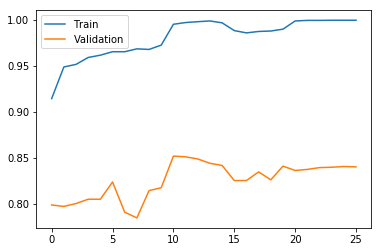

In [0]:
plt.plot(metrics.train_acc, label="Train")
plt.plot(metrics.val_acc, label="Validation")
plt.legend()
plt.show()

### Обучение без изменения batch_size

In [0]:
batch_size = 32

n = len(X_train)
metrics = FitMetrics()

for epoch in range(100):
    order = np.random.permutation(n)
  
    print("\r", end=f"Epoch {epoch}: ")
    for start_index in range(0, n, batch_size):
        
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index + batch_size]

        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        preds = custom_net.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()
    
    # Calculate train acc and loss
    metrics.append(custom_net, X_train, y_train, X_test, y_test)
    print(metrics.latest_summary())


Epoch 0: loss: 0.9599933624267578, acc: 0.7112500071525574, val_loss: 0.976076602935791, val_acc: 0.699999988079071
Epoch 1: loss: 0.6985705494880676, acc: 0.7799999713897705, val_loss: 0.7547516226768494, val_acc: 0.7562500238418579
Epoch 2: loss: 0.5782284140586853, acc: 0.8187500238418579, val_loss: 0.6643613576889038, val_acc: 0.784375011920929
Epoch 3: loss: 0.5075091123580933, acc: 0.8393750190734863, val_loss: 0.6502072215080261, val_acc: 0.7875000238418579
Epoch 4: loss: 0.4251152276992798, acc: 0.8631250262260437, val_loss: 0.6478458642959595, val_acc: 0.8031250238418579
Epoch 5: loss: 0.36665505170822144, acc: 0.8806250095367432, val_loss: 0.6459535956382751, val_acc: 0.796875
Epoch 6: loss: 0.3733425438404083, acc: 0.8787500262260437, val_loss: 0.6072012186050415, val_acc: 0.8187500238418579
Epoch 7: loss: 0.2772292494773865, acc: 0.9112499952316284, val_loss: 0.7050321698188782, val_acc: 0.796875
Epoch 8: loss: 0.2442813664674759, acc: 0.9262499809265137, val_loss: 0.715996

KeyboardInterrupt: ignored

#### График обучения

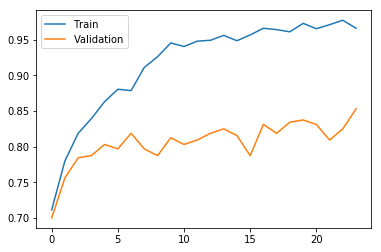

In [0]:
plt.plot(metrics.train_acc, label="Train")
plt.plot(metrics.val_acc, label="Validation")
plt.legend()
plt.show()